In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
rating_matrix = np.array([[5,3,0,1], [4,0,0,1], [1,1,0,5], [1,0,0,4], [0,1,5,4]])

feature_num = 2
user_num, item_num = rating_matrix.shape
user_matrix = np.random.random_sample((user_num, feature_num))
item_matrix = np.random.random_sample((item_num, feature_num))

In [3]:
def sgd(data_matrix, user, item, alpha=0.0002, lam=0.02, iter_num=5000):
    results = []
    for step in range(iter_num):
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u][i] != 0:
                    e_ui = data_matrix[u][i] - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (2 * e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (2 * e_ui * user[u,:] - lam * item[i,:])
                    
        e = 0            
        for i in range(data_matrix.shape[0]):
            for j in range(data_matrix.shape[1]):
                if data_matrix[i][j] != 0:
                    e += pow(data_matrix[i][j] - np.dot(user[i,:], item[j,:]), 2)
                    e += lam/2 * np.sum((pow(user[i,:], 2) + pow(item[j,:], 2)), axis=0)
                        
        results.append(e)
        # 当 e < 0.001 时收敛
        if e < 0.001:
            break
            
    return user, item, results

In [4]:
user, item, results = sgd(rating_matrix, user_matrix, item_matrix)

matrix_predict = np.dot(user, item.T)
print(matrix_predict)

[[5.02578942 2.86306535 4.50005916 0.99788069]
 [3.94275951 2.25166301 3.70352865 0.99677501]
 [1.09371608 0.74672083 4.82295364 4.96452901]
 [0.95500732 0.64257568 3.91776027 3.97236549]
 [2.19314342 1.34320549 4.8801324  4.03756733]]


In [5]:
def get_miu(data_matrix):

    non_zero_num = 0
    non_zero_sum = 0
    for i in range(data_matrix.shape[0]):
        for j in range(data_matrix.shape[1]):
            if data_matrix[i][j] != 0:
                non_zero_num += 1
                non_zero_sum += data_matrix[i][j]
    return non_zero_sum/non_zero_num, non_zero_num

miu, non_zero_num = get_miu(rating_matrix)

def cal_MSE(data_matrix, predict_matrix, non_zero_num):
    filter_matrix_entry = data_matrix > 0
    predict_matrix_filtered = predict_matrix * filter_matrix_entry
    diff_matrix = (predict_matrix_filtered - data_matrix) * (predict_matrix_filtered - data_matrix)
    mse = (1/non_zero_num) * (diff_matrix.sum())
    
    return mse

In [6]:
def sgd_bias(data_matrix, user, item, miu, alpha=0.0002, lam=0.02, iter_num=5000):
    results = []
    
    b_u = [1] * rating_matrix.shape[0]
    b_i = [1] * rating_matrix.shape[1]
    for j in range(iter_num):
        for u in range(data_matrix.shape[0]):
            for i in range(data_matrix.shape[1]):
                if data_matrix[u][i] != 0:
                    b_ui = b_u[u] + b_i[i] + miu
                    e_ui = data_matrix[u][i] - b_ui - sum(user[u,:] * item[i,:])
                    user[u,:] += alpha * (2 * e_ui * item[i,:] - lam * user[u,:])
                    item[i,:] += alpha * (2 * e_ui * user[u,:] - lam * item[i,:])
                    b_u[u] += alpha * (e_ui - lam * b_u[u])
                    b_i[i] += alpha * (e_ui - lam * b_i[i])
                    
        e = 0            
        matrix_predict_bias = np.dot(user, item.T)
        for i in range(data_matrix.shape[0]):
            for j in range(data_matrix.shape[1]):
                if data_matrix[i][j] != 0:
                    matrix_predict_bias[i][j] += (miu + b_u[i] + b_i[j])
                    e += pow((data_matrix[i][j] - matrix_predict_bias[i][j]), 2)
                    e += lam/2 * np.sum((pow(user[i,:], 2) + pow(item[j,:], 2)), axis=0)
                    
        results.append(e)
        # 当 e < 0.001 时收敛
        if e < 0.001:
            break       
            
    return user, item, b_u, b_i, results

In [7]:
user_bias, item_bias, b_u, b_i, results_bias = sgd_bias(rating_matrix, user_matrix, item_matrix, miu)

matrix_predict_bias = np.dot(user_bias, item_bias.T)
for u in range(matrix_predict_bias.shape[0]):
    for i in range(matrix_predict_bias.shape[1]):
        matrix_predict_bias[u][i] += (miu + b_u[u] + b_i[i])
print(matrix_predict_bias)

[[4.92553835 3.03041091 6.80204679 0.96710211]
 [4.05164891 2.40239424 6.27515094 1.06658034]
 [0.98111744 1.01592582 5.91284    4.95384455]
 [1.03967217 0.74860372 5.85609691 4.0246456 ]
 [1.04189923 1.01585921 4.99550074 3.99092884]]


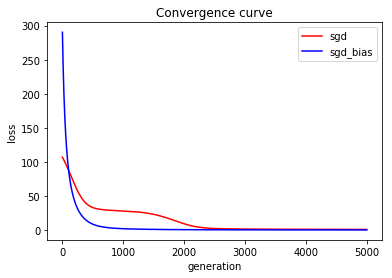

In [8]:
x=range(len(results))

plt.plot(x, results, 'r', label='sgd' )
plt.plot(x, results_bias, 'b', label='sgd_bias')
plt.title("Convergence curve")
plt.xlabel("generation")
plt.ylabel("loss")
plt.legend()
plt.show()

In [9]:
print('sgd: ', cal_MSE(rating_matrix, matrix_predict, non_zero_num))
print('sgd_bias: ', cal_MSE(rating_matrix, matrix_predict_bias, non_zero_num))

sgd:  0.017942796067478638
sgd_bias:  0.001532924799775961
